In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Titanic survival classification
**My competition getting started on the Titanic desaster based on the Udemy course "Data Science and ML Bootcamp", by Jose Portilla.**

In [2]:
# Reading train data
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Plots to get acquanted with data.

**Missing data**

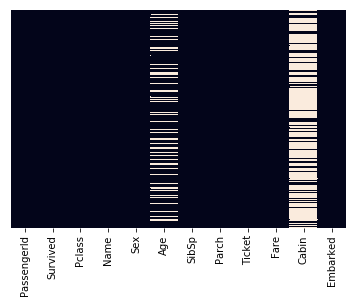

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Observations
- Too many cabin data is missing, so we are going to drop it. 
- Only two entries are missing in the Embarked cathegory.
- We need to explore how is age correlated with other variables before moving on. Too start with, we note that age is the most correlated with PClass and with SipSp

### We drop the Name and Ticked cathegories as we don't know yet how to treat them

In [6]:
train.drop('Name',axis=1,inplace=True)
train.drop('Ticket',axis=1,inplace=True)
train.drop('PassengerId',axis=1,inplace=True) #Obviously PassengerId is also irrelevant

### Treatment of Cabin missing data

In [7]:
#Drop missing data
train.drop('Cabin',axis=1,inplace=True)

### Treatment of Embarked missing data

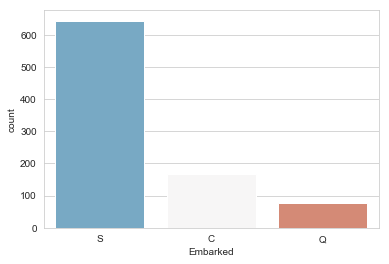

In [8]:
#Check is one Embarked value is overwelmingly
sns.set_style('whitegrid')
sns.countplot(x='Embarked',data=train,palette='RdBu_r')

In [9]:
# Since the vast mayority of Embarked has value 'S', we replace the two missing values this way
def impute_Embarked(cols):
    embarked = cols
    if pd.isnull(embarked):
        return 'S'
    else:
        return embarked
train['Embarked']=train['Embarked'].apply(impute_Embarked)

### Converting sex and embarked to numerical values

In [10]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

train.drop(['Sex','Embarked'],axis=1,inplace=True)

train = pd.concat([train,sex,embark],axis=1)


In [11]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Treatment of Age missing data

So, since only 20%ish age values are missing we are going to estimate them using linear regresion. For this purpose we first examine to which variables it is correlated to.

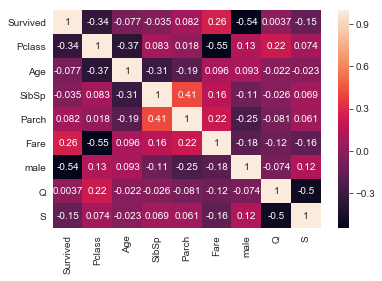

In [12]:
sns.heatmap(train.corr(),annot=True)

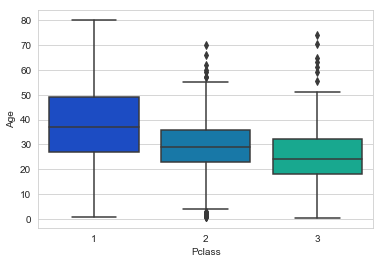

In [13]:
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

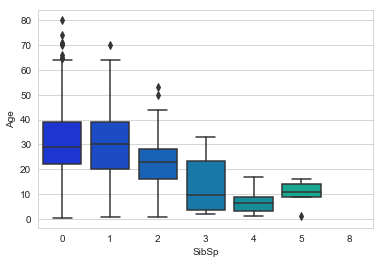

In [14]:
sns.boxplot(x='SibSp',y='Age',data=train,palette='winter')

In [15]:
X_age_train=train[train['Age'].notnull()][["Pclass",'SibSp']]
y_age_train=train[train['Age'].notnull()]['Age']

In [16]:
from sklearn.linear_model import LinearRegression
age_lm = LinearRegression()
age_lm.fit(X_age_train,y_age_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
age_lm.intercept_, age_lm.coef_[0],age_lm.coef_[1]

(45.54867097857938, -6.066737067651516, -4.448092846082533)

In [18]:
def impute_age(cols):
    Pclass = cols[0]
    SibSp=cols[1]
    Age = cols[2]
    
    if pd.isnull(Age):

        return age_lm.intercept_ + Pclass *age_lm.coef_[0] + SibSp *age_lm.coef_[1]

    else:
        return Age

In [19]:
train['Age']=train[['Pclass','SibSp','Age']].apply(impute_age,axis=1)
train.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.00000,1,0,7.2500,1,0,1
1,1,1,38.00000,1,0,71.2833,0,0,0
2,1,3,26.00000,0,0,7.9250,0,0,1
3,1,1,35.00000,1,0,53.1000,0,0,1
4,0,3,35.00000,0,0,8.0500,1,0,1
5,0,3,27.34846,0,0,8.4583,1,1,0
6,0,1,54.00000,0,0,51.8625,1,0,1
7,0,3,2.00000,3,1,21.0750,1,0,1
8,1,3,27.00000,0,2,11.1333,0,0,1
9,1,2,14.00000,1,0,30.0708,0,0,0


# Building a Logistic Regression model



In [20]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()

logmodel.fit(train.drop('Survived',axis=1,inplace=False),train['Survived'])

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
# Define function to process test data

def process_data(data):
    data.drop('Name',axis=1,inplace=True)
    data.drop('Ticket',axis=1,inplace=True)
    data.drop('Cabin',axis=1,inplace=True)
    data.drop('PassengerId',axis=1,inplace=True)
    
    data['Embarked']=data['Embarked'].apply(impute_Embarked)
    
    sex = pd.get_dummies(data['Sex'],drop_first=True)
    embark = pd.get_dummies(data['Embarked'],drop_first=True)
    
    data.drop(['Sex','Embarked'],axis=1,inplace=True)
    data = pd.concat([data,sex,embark],axis=1)
    
    data['Age']=data[['Pclass','SibSp','Age']].apply(impute_age,axis=1)
    return data

In [22]:
test = pd.read_csv('test.csv')

X_test=process_data(test)
X_test.isnull().sum(), X_test.head()

(Pclass    0
 Age       0
 SibSp     0
 Parch     0
 Fare      1
 male      0
 Q         0
 S         0
 dtype: int64,    Pclass   Age  SibSp  Parch     Fare  male  Q  S
 0       3  34.5      0      0   7.8292     1  1  0
 1       3  47.0      1      0   7.0000     0  0  1
 2       2  62.0      0      0   9.6875     1  1  0
 3       3  27.0      0      0   8.6625     1  0  1
 4       3  22.0      1      1  12.2875     0  0  1)

In [23]:
#There is still a missing value
X_test.isnull().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      1
male      0
Q         0
S         0
dtype: int64

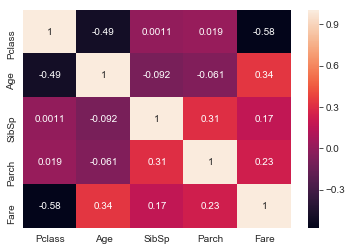

In [24]:
sns.heatmap(test.corr(),annot=True)

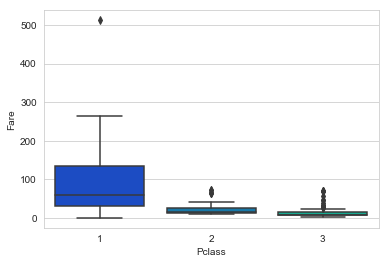

In [25]:
sns.boxplot(x='Pclass',y='Fare',data=X_test,palette='winter')

In [26]:
X_test[X_test['Fare'].isnull()==True]

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
152,3,60.5,0,0,NaN,1,0,1


In [27]:
mean_fare_thirdclass=X_test[X_test['Pclass']==3]['Fare'].mean()
mean_fare_thirdclass

12.459677880184334

In [28]:
X_test['Fare'][152]=mean_fare_thirdclass
X_test['Fare'][152]

/Users/rene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


12.459677880184334

In [29]:
X_test.isnull().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
male      0
Q         0
S         0
dtype: int64

In [30]:
test_prediction = logmodel.predict(X_test)

In [31]:
test_pred = pd.DataFrame(test_prediction, columns= ['Survived'])

In [32]:
test = pd.read_csv('test.csv')

In [33]:
test_result = pd.concat([test, test_pred], axis=1, join='inner')
test_result.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [34]:
df_submit= test_result[['PassengerId' ,'Survived']]

In [35]:
df_submit.to_csv('predictions.csv' , index=False)